In [1]:
%load_ext autoreload
%autoreload 2

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
%matplotlib inline

import argparse
import os
import os.path as osp
import numpy as np
import torch  # put this before scipy import
from scipy.misc import imread, imresize
import sys
sys.path.insert(0, '../tools')

from mattnet import MattNet

/root/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# box functions
def xywh_to_xyxy(boxes):
    """Convert [x y w h] box format to [x1 y1 x2 y2] format."""
    return np.hstack((boxes[:, 0:2], boxes[:, 0:2] + boxes[:, 2:4] - 1))

def show_attn(img_path, box, attn):
    """
    box : [xywh]
    attn: 49
    """
    img = imread(img_path)
    attn = np.array(attn).reshape(7,7)
    x,y,w,h = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    roi = img[y:y+h-1, x:x+w-1]
    attn = imresize(attn, [h,w])
    plt.imshow(roi)
    plt.imshow(attn, alpha=0.7)
    
def show_boxes(img_path, boxes, colors, texts=None, masks=None):
    # boxes [[xyxy]]
    img = imread(img_path)
    plt.imshow(img)
    ax = plt.gca()
    for k in range(boxes.shape[0]):
        box = boxes[k]
        xmin, ymin, xmax, ymax = list(box)
        coords = (xmin, ymin), xmax - xmin + 1, ymax - ymin + 1
        color = colors[k]
        ax.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        if texts is not None:
            ax.text(xmin, ymin, texts[k], bbox={'facecolor':color, 'alpha':0.5})
    # show mask
    if masks is not None:
        for k in range(len(masks)):
            mask = masks[k]
            m = np.zeros( (mask.shape[0], mask.shape[1], 3))
            m[:,:,0] = 0; m[:,:,1] = 0; m[:,:,2] = 1.
            ax.imshow(np.dstack([m*255, mask*255*0.4]).astype(np.uint8)) 

In [3]:
# arguments
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='refcoco', help='dataset name: refclef, refcoco, refcoco+, refcocog')
parser.add_argument('--splitBy', type=str, default='unc', help='splitBy: unc, google, berkeley')
parser.add_argument('--model_id', type=str, default='mrcn_cmr_with_st', help='model id name')
args = parser.parse_args('')

In [4]:
# MattNet
mattnet = MattNet(args)

/root/anaconda3/lib/python3.6/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'layers.joint_match.JointMatching' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


MatNet [refcoco_unc's mrcn_cmr_with_st] loaded in 3.96 seconds.
Using config:
{'ANCHOR_RATIOS': [0.5, 1, 2],
 'ANCHOR_SCALES': [4, 8, 16, 32],
 'DATA_DIR': '/root/MAttNet/pyutils/mask-faster-rcnn/data',
 'EXP_DIR': 'res101',
 'MASK_SIZE': 14,
 'MATLAB': 'matlab',
 'MOBILENET': {'DEPTH_MULTIPLIER': 1.0,
               'FIXED_LAYERS': 5,
               'REGU_DEPTH': False,
               'WEIGHT_DECAY': 4e-05},
 'PIXEL_MEANS': array([[[ 102.9801,  115.9465,  122.7717]]]),
 'POOLING_ALIGN': False,
 'POOLING_MODE': 'crop',
 'POOLING_SIZE': 7,
 'RESNET': {'FIXED_BLOCKS': 1, 'MAX_POOL': False},
 'RNG_SEED': 3,
 'ROOT_DIR': '/root/MAttNet/pyutils/mask-faster-rcnn',
 'TEST': {'BBOX_REG': True,
          'HAS_RPN': True,
          'MAX_SIZE': 1000,
          'MODE': 'nms',
          'NMS': 0.3,
          'PROPOSAL_METHOD': 'gt',
          'RPN_NMS_THRESH': 0.7,
          'RPN_POST_NMS_TOP_N': 300,
          'RPN_PRE_NMS_TOP_N': 6000,
          'RPN_TOP_N': 5000,
          'SCALES': [600],
     

In [5]:
# image path
IMAGE_DIR = '../data/images/mscoco/images/train2014'
img_path = osp.join(IMAGE_DIR, 'COCO_train2014_'+str(229598).zfill(12)+'.jpg')

/root/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


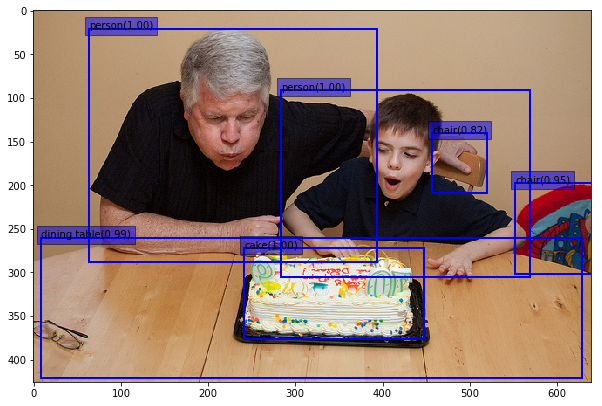

In [11]:
# forward image
img_data = mattnet.forward_image(img_path, nms_thresh=0.3, conf_thresh=0.50)
# show masks
plt.rcParams['figure.figsize'] = (10., 8.)
dets = img_data['dets']
show_boxes(img_path, xywh_to_xyxy(np.array([det['box'] for det in dets])), 
           ['blue']*len(dets), ['%s(%.2f)' % (det['category_name'], det['score']) for det in dets])

In [26]:
# comprehend expression
expr = 'man in black'
entry = mattnet.comprehend(img_data, expr)

sub(0.87): (man,0.37)(in,0.11)(black,0.52)
loc(0.12): (man,0.26)(in,0.41)(black,0.33)
rel(0.01): (man,0.43)(in,0.24)(black,0.34)
[('guy', 0.6933112144470215), ('black', 0.2114163637161255), ('woman', 0.09637352079153061), ('shirt', 0.08198130130767822), ('blue', 0.06089939549565315)]


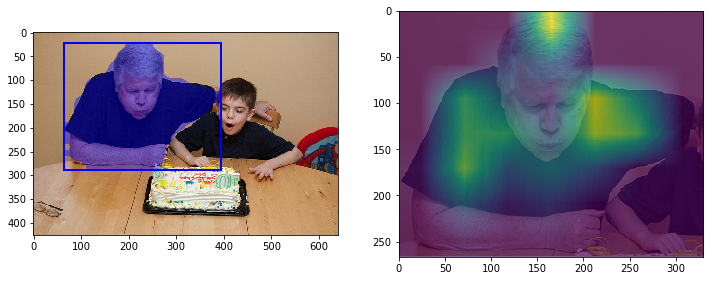

In [27]:
# visualize
tokens = expr.split()
print('sub(%.2f):' % entry['weights'][0], ''.join(['(%s,%.2f)'% (tokens[i], s) for i, s in enumerate(entry['sub_attn'])]))
print('loc(%.2f):' % entry['weights'][1], ''.join(['(%s,%.2f)'% (tokens[i], s) for i, s in enumerate(entry['loc_attn'])]))
print('rel(%.2f):' % entry['weights'][2], ''.join(['(%s,%.2f)'% (tokens[i], s) for i, s in enumerate(entry['rel_attn'])]))
# predict attribute on the predicted object
print(entry['pred_atts'])
# show prediction
plt.rcParams['figure.figsize'] = (12., 8.)
fig = plt.figure()
plt.subplot(121)
show_boxes(img_path, xywh_to_xyxy(np.vstack([entry['pred_box']])), ['blue'], texts=None, masks=[entry['pred_mask']])
plt.subplot(122)
show_attn(img_path, entry['pred_box'], entry['sub_grid_attn'])